# Generating the cluster number density

We will compute the cluster number density, $n(s, p)$, from sets of percolating two-dimensional clusters. As the cluster number density is not known analytically in all but the simplest systems, i.e., the infinite dimensional and the one-dimensional system, we will estimate it numerically. This is done by
\begin{align}
    n(s, p; L) \approx \frac{N_s}{ML^d},
\end{align}
where $s$ is the size of the cluster, $p$ the probability for a site to be set in the system, $L$ the length of a side in the system (assuming equal lengths for all sides), $d$ the dimension of the problem ($L^d$ is the volume), $N_s$ the number of clusters of size $s$ and $M$ the number of simulations performed.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage
import tqdm
import sklearn.linear_model
from uncertainties import ufloat

In [2]:
def is_percolating(prop, num_rows, num_cols):
    min_row, min_col, max_row, max_col = prop.bbox

    return max_row - min_row == num_rows or max_col - min_col == num_cols

In [3]:
def compute_cluster_area(system, p, remove_percolating_cluster=True):
    mat = system < p
    # Label and count the number of connected clusters
    labels, num_features = scipy.ndimage.measurements.label(mat)
    s_list = skimage.measure.regionprops(labels)

    new_s_list = []
    if remove_percolating_cluster:
        for s in s_list:
            if is_percolating(s, *system.shape):
                continue
            new_s_list.append(s)
    else:
        new_s_list = s_list
            
    area = list(map(lambda prop: prop.area, new_s_list))

    return area

Example code to plot a specific prop in a system.

```python
box = s[1].bbox
plt.matshow(labels[box[0]:box[2], box[1]:box[3]], cmap="hsv")
plt.show()
```

In [4]:
def compute_cluster_number_density(L, M, p, a=1.2):
    area = []
    for i in range(M):
        z = np.random.rand(L, L)
        area.extend(compute_cluster_area(z, p))

    n, s = np.histogram(area, L ** 2)

    nsp = n / (L ** 2 * M)

    # Logarithmic binning
    logamax = np.ceil(np.log(max(s)) / np.log(a))
    bins = a ** np.arange(0, logamax, 1)

    nl, _ = np.histogram(area, bins)
    ds = np.diff(bins)
    sl = (bins[1:] + bins[:-1]) * 0.5
    nsl = nl / (M * L ** 2 * ds)

    return sl, nsl

In [5]:
p_c = 0.59275

Below we plot the cluster number density as $p \to p_c = 0.59275$ from below.

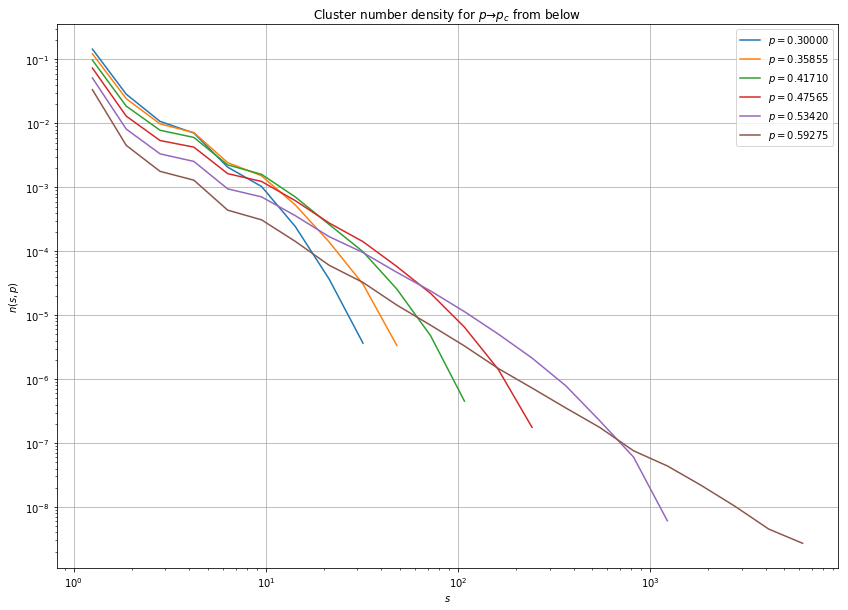

In [13]:
fig = plt.figure(figsize=(14, 10))

for p in tqdm.tqdm_notebook(np.linspace(0.3, p_c, 6)):
    plt.loglog(
        *compute_cluster_number_density(200, 200, p, a=1.5),
        label=rf"$p = {p:.5f}$"
    )

plt.legend()
plt.grid()
plt.title(r"Cluster number density for $p \to p_c$ from below")
plt.xlabel(r"$s$")
plt.ylabel(r"$n(s, p)$")
plt.show()

In this figure we can see how the cluster number density follows a seemingly straight line for a while, before dropping of sharply when $p$ is a little off from the critical percolation probability. This shows how the cluster number density at the critical percolation probability follows a power law as the axes are logarithmic.

Here we repeat the experiment, but for $p \to p_c$ from above.

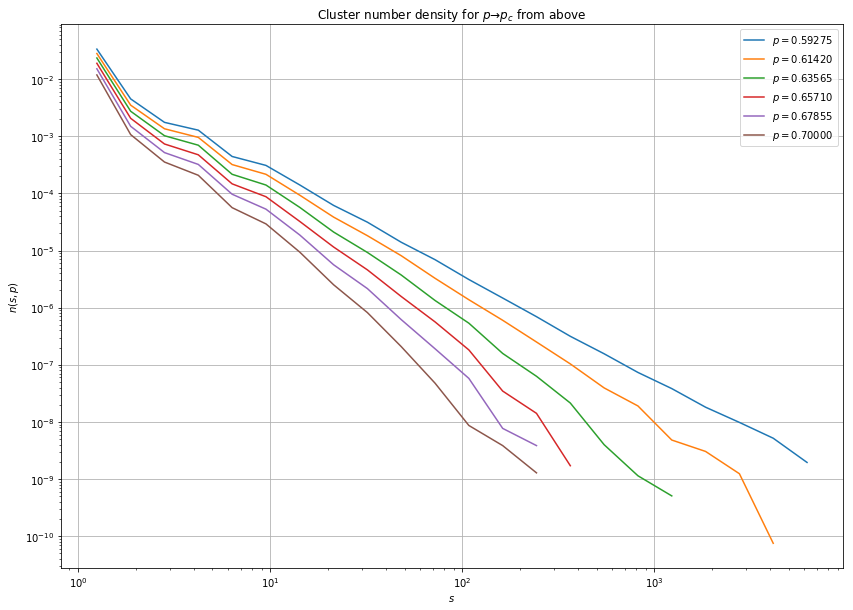

In [14]:
fig = plt.figure(figsize=(14, 10))

for p in tqdm.tqdm_notebook(np.linspace(p_c, 0.7, 6)):
    plt.loglog(
        *compute_cluster_number_density(200, 200, p, a=1.5),
        label=rf"$p = {p:.5f}$"
    )

plt.legend()
plt.grid()
plt.title(r"Cluster number density for $p \to p_c$ from above")
plt.xlabel(r"$s$")
plt.ylabel(r"$n(s, p)$")
plt.show()

When $p \to p_c$ from above, we see that all cluster number densities behave in a power law fashion. Why is that?

## The cluster number density at critical percolation probability

For $p = p_c = 0.59275$, we explore how the cluster number density changes for a system of $L = 2^k$ for $k = \{4, \dots, 9\}$.
We wish to show how the cluster number density deviates from the power law behavior, when $p = p_c$. We expect that
\begin{align}
    n(s, p_c; L) = F\left(\frac{s}{s_{\xi}}\right) s^{-\tau} \propto s^{-\tau},
\end{align}
where $F$ is some function which we try to ignore.
By taking the logarithm on both sides, we get an expression for $\tau$.
\begin{gather}
    \log\left[n(s, p_c; L)\right]
    =
    -\tau \log\left[ s \right]
    + \log\left[ F\left(\frac{s}{s_{\xi}}\right) \right].
\end{gather}
We use linear regression to get an estimate for $-\tau$.

In [31]:
L_arr = 2 ** np.arange(4, 11)
true_tau = 187 / 91

For L = 16: -tau = -1.6961	C = -4.7898
	(i=0, j=1)	tau = -2.3382
	(i=0, j=2)	tau = -1.8969
	(i=0, j=3)	tau = -1.8120
	(i=0, j=4)	tau = -1.7620
	(i=0, j=5)	tau = -1.7436
	(i=1, j=2)	tau = -1.4555
	(i=1, j=3)	tau = -1.5489
	(i=1, j=4)	tau = -1.5700
	(i=1, j=5)	tau = -1.5949
	(i=2, j=3)	tau = -1.6422
	(i=2, j=4)	tau = -1.6272
	(i=2, j=5)	tau = -1.6414
	(i=3, j=4)	tau = -1.6122
	(i=3, j=5)	tau = -1.6410
	(i=4, j=5)	tau = -1.6699
For L = 32: -tau = -1.7665	C = -5.0447
	(i=0, j=1)	tau = -2.4407
	(i=0, j=2)	tau = -2.0133
	(i=0, j=3)	tau = -1.9135
	(i=0, j=4)	tau = -1.8812
	(i=0, j=5)	tau = -1.8182
	(i=0, j=6)	tau = -1.8295
	(i=0, j=7)	tau = -1.8108
	(i=1, j=2)	tau = -1.5860
	(i=1, j=3)	tau = -1.6499
	(i=1, j=4)	tau = -1.6947
	(i=1, j=5)	tau = -1.6625
	(i=1, j=6)	tau = -1.7072
	(i=1, j=7)	tau = -1.7058
	(i=2, j=3)	tau = -1.7138
	(i=2, j=4)	tau = -1.7490
	(i=2, j=5)	tau = -1.6880
	(i=2, j=6)	tau = -1.7375
	(i=2, j=7)	tau = -1.7298
	(i=3, j=4)	tau = -1.7843
	(i=3, j=5)	tau = -1.6752
	(i=3, j=6)	

For L = 1024: -tau = -1.9249	C = -5.4241
	(i=0, j=1)	tau = -2.6746
	(i=0, j=2)	tau = -2.2079
	(i=0, j=3)	tau = -2.1093
	(i=0, j=4)	tau = -2.0699
	(i=0, j=5)	tau = -2.0518
	(i=0, j=6)	tau = -2.0427
	(i=0, j=7)	tau = -2.0351
	(i=0, j=8)	tau = -2.0273
	(i=0, j=9)	tau = -2.0230
	(i=0, j=10)	tau = -2.0141
	(i=0, j=11)	tau = -2.0073
	(i=0, j=12)	tau = -1.9923
	(i=0, j=13)	tau = -1.9829
	(i=0, j=14)	tau = -1.9720
	(i=0, j=15)	tau = -1.9428
	(i=0, j=16)	tau = -1.9216
	(i=1, j=2)	tau = -1.7412
	(i=1, j=3)	tau = -1.8267
	(i=1, j=4)	tau = -1.8683
	(i=1, j=5)	tau = -1.8961
	(i=1, j=6)	tau = -1.9163
	(i=1, j=7)	tau = -1.9286
	(i=1, j=8)	tau = -1.9349
	(i=1, j=9)	tau = -1.9416
	(i=1, j=10)	tau = -1.9407
	(i=1, j=11)	tau = -1.9406
	(i=1, j=12)	tau = -1.9303
	(i=1, j=13)	tau = -1.9253
	(i=1, j=14)	tau = -1.9180
	(i=1, j=15)	tau = -1.8905
	(i=1, j=16)	tau = -1.8714
	(i=2, j=3)	tau = -1.9122
	(i=2, j=4)	tau = -1.9319
	(i=2, j=5)	tau = -1.9478
	(i=2, j=6)	tau = -1.9601
	(i=2, j=7)	tau = -1.9661
	(i=2, j=

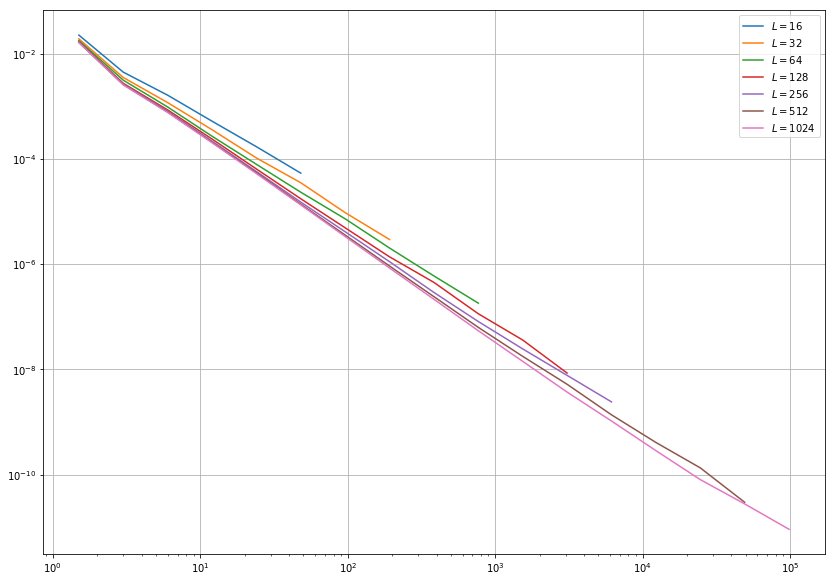

In [35]:
fig = plt.figure(figsize=(14, 10))
a = 2
tau_list = []

for L in tqdm.tqdm_notebook(L_arr):
    sl, nsl = compute_cluster_number_density(L, 200, p=p_c, a=a)

    log_sl = np.log(sl) / np.log(a)
    log_nsl = np.log(nsl) / np.log(a)
    
    plt.loglog(sl, nsl, label=rf"$L = {L}$")
    clf = sklearn.linear_model.LinearRegression(
        fit_intercept=True
    ).fit(log_sl[:, None], log_nsl[:, None])

    tau = clf.coef_[0, 0]
    C = clf.intercept_[0]

    print(f"For L = {L}: -tau = {tau:.4f}\tC = {C:.4f}")

    tau_arr = np.zeros(int(len(log_nsl) * (len(log_nsl) - 1) / 2))
    index = 0
    for i in range(len(log_nsl)):
        for j in range(i + 1, len(log_nsl)):
            tau = (log_nsl[j] - log_nsl[i]) / (log_sl[j] - log_sl[i])
            print(f"\t(i={i}, j={j})\ttau = {tau:.4f}")
            tau_arr[index] = tau
            index += 1

    tau_list.append(tau_arr.copy())

plt.legend()
plt.grid()
plt.show()

In [44]:
for tau in tau_list:
    print(f"tau = {np.mean(tau):.2f} +/- {np.std(tau):.2f}")

tau = -1.70 +/- 0.20
tau = -1.77 +/- 0.16
tau = -1.81 +/- 0.13
tau = -1.86 +/- 0.13
tau = -1.88 +/- 0.12
tau = -1.91 +/- 0.11
tau = -1.92 +/- 0.11


In [40]:
unc_tau = [ufloat(np.mean(tau), np.std(tau)) for tau in tau_list]

In [42]:
for tau in unc_tau:
    print(f"error tau = {true_tau + tau}")

error tau = 0.35+/-0.20
error tau = 0.28+/-0.16
error tau = 0.24+/-0.13
error tau = 0.19+/-0.13
error tau = 0.18+/-0.12
error tau = 0.15+/-0.11
error tau = 0.13+/-0.11
